In [2]:
import sys
sys.path[1] = '/home/sgururaj/src/flow_graphs/code/'

In [3]:
from collections import Counter
import os

import dill
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from tqdm.auto import tqdm
import wandb

from evaluation import get_transfer_eval_filename

In [4]:
tqdm.pandas()

In [5]:
dataset_names = ["risec", "japflow", "mscorpus"]
FEWSHOT=10

In [6]:
datasets = {}

for dataset in dataset_names:
    with open(f"data/{dataset}/data_amr.dill", "rb") as f:
       datasets[dataset] = dill.load(f)

In [7]:
for dataset_name, dataset in datasets.items():
    print(dataset_name)
    print(f"Training set: {len(dataset['train']['rels'])}")
    print(f"Dev set: {len(dataset['dev']['rels'])}")
    print(f"Test set: {len(dataset['test']['rels'])}")
    print()



risec
Training set: 3689
Dev set: 1689
Test set: 2213

japflow
Training set: 13958
Dev set: 1745
Test set: 1745

mscorpus
Training set: 12330
Dev set: 2287
Test set: 3782



In [8]:
dataset_labels = {}

for dataset_name, dataset in datasets.items():
    dataset_train_labels = [instance["label"] for instance in dataset["train"]["rels"]]
    train_label_counter = Counter(dataset_train_labels)

    dataset_labels[dataset_name] = train_label_counter
    print(dataset_name)
    print(train_label_counter)
    print()

dataset_labels

risec
Counter({'Arg_PPT': 2219, 'ArgM_TMP': 440, 'Arg_GOL': 349, 'ArgM_LOC': 231, 'ArgM_MNR': 227, 'ArgM_PRP': 73, 'Arg_DIR': 42, 'Arg_PRD': 39, 'ArgM_SIM': 33, 'ArgM_INT': 26, 'Arg_PAG': 10})

japflow
Counter({'targ': 5458, 'other-mod': 2426, 'dest': 1759, 'f-eq': 980, 'f-part-of': 660, 'agent': 600, 't-comp': 557, 'v-tm': 553, 't-eq': 267, 'f-comp': 267, 'a-eq': 222, 't-part-of': 190, 'f-set': 19})

mscorpus
Counter({'Information_Of': 3138, 'Next_Operation': 2251, 'Number_Of': 2127, 'Participant_Material': 1462, 'Condition_Of': 1386, 'Recipe_Precursor': 674, 'Apparatus_Of': 358, 'Solvent_Material': 355, 'Recipe_Target': 271, 'Coref_Of': 177, 'Type_Of': 131})



{'risec': Counter({'ArgM_LOC': 231,
          'ArgM_MNR': 227,
          'Arg_PPT': 2219,
          'ArgM_TMP': 440,
          'Arg_DIR': 42,
          'Arg_GOL': 349,
          'ArgM_INT': 26,
          'ArgM_PRP': 73,
          'Arg_PAG': 10,
          'Arg_PRD': 39,
          'ArgM_SIM': 33}),
 'japflow': Counter({'targ': 5458,
          'dest': 1759,
          'other-mod': 2426,
          'f-eq': 980,
          'agent': 600,
          't-eq': 267,
          'v-tm': 553,
          't-comp': 557,
          'a-eq': 222,
          'f-part-of': 660,
          'f-comp': 267,
          't-part-of': 190,
          'f-set': 19}),
 'mscorpus': Counter({'Information_Of': 3138,
          'Coref_Of': 177,
          'Recipe_Precursor': 674,
          'Number_Of': 2127,
          'Next_Operation': 2251,
          'Recipe_Target': 271,
          'Apparatus_Of': 358,
          'Solvent_Material': 355,
          'Participant_Material': 1462,
          'Condition_Of': 1386,
          'Type_Of': 131})

risec
11
japflow
13
mscorpus
11


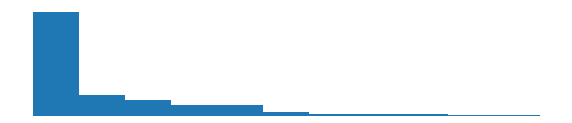

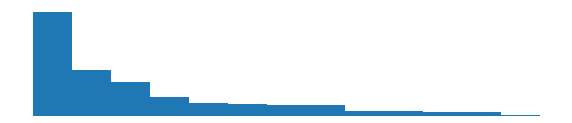

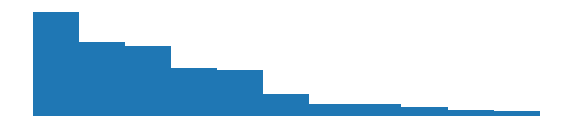

In [44]:
for dataset in datasets:
    fig, ax = plt.subplots(figsize=(10,2))
    ax.set_axis_off()
    ax.bar(*zip(*dataset_labels[dataset].most_common()), width=1.0)
    fig.savefig(f"{dataset}_label_distro.png", bbox_inches="tight")
    print(dataset)
    print(len(dataset_labels[dataset]))

In [8]:
api = wandb.Api(timeout=30)a

In [38]:
filters = {
    "state": "finished"
}

# from-scratch sweep
sweeps = ["masb7v5w", "v828yikt", "x6qwchbj", "sgk8b8c5", "009z7n7n", "15bjmhl0"]


runs = []
for sweep_id in sweeps:
    sweep = api.sweep(f"flow-graphs-cmu/narrative-flow-simplified/{sweep_id}")
    runs.extend(sweep.runs)

df_dicts = []

for run in tqdm(runs):
    try:
        test_f1  = run.history(keys=["test_f1"], pandas=False)[0]["test_f1"]
        df_dicts.append({**run.config, "test_f1": test_f1, "name": run.name})
    except:
        continue

results_df = pd.DataFrame(df_dicts)

  0%|          | 0/252 [00:00<?, ?it/s]

In [39]:
def get_per_label_performance_per_row(row):
    filename = get_transfer_eval_filename(src_dataset=row["src_dataset"], tgt_dataset=row["tgt_dataset"], fewshot=row["fewshot"], split="test", seed=row["seed"], case=row["case"])
    run_df = pd.read_csv(os.path.join("results", filename))
    labels = sorted(run_df["labels"].unique().tolist())
    p, r , f, s = precision_recall_fscore_support(y_true=run_df["labels"], y_pred=run_df["predictions"], labels=labels)
    f1_by_label = {label: f1 for label, f1 in zip(labels, f)}
    return f1_by_label

def get_corresponding_plaintext_row(row, df):
    return df[(pd.DataFrame([df[thing] == row[thing] for thing in ["src_dataset", "tgt_dataset", "fewshot", "seed"]]).all()) & (df["case"] ==  "plaintext")].iloc[0]

In [40]:
results_df = results_df.join(results_df.apply(get_per_label_performance_per_row, axis=1, result_type="expand"))


In [41]:
tgt_dataset = "risec"

pair_df = results_df[(results_df["tgt_dataset"] == tgt_dataset) & (results_df["fewshot"] == 10)][["name", "src_dataset", "tgt_dataset", "case", "fewshot", "seed", "test_f1", *dataset_labels[tgt_dataset]]]
grouped = pair_df.groupby(["src_dataset", "tgt_dataset", "case"]).mean()
diff = grouped.apply(lambda row: (row - grouped.loc[row.name[0], row.name[1], "plaintext"]) * 100, axis=1)
diff

fewshot  seed   test_f1   ArgM_LOC  \
src_dataset tgt_dataset case                                               
japflow     risec       amr_residual      0.0   0.0  3.677388   1.803051   
                        dep_residual      0.0   0.0  4.050932   1.378148   
                        plaintext         0.0   0.0  0.000000   0.000000   
mscorpus    risec       amr_residual      0.0   0.0  4.216022  10.949718   
                        dep_residual      0.0   0.0  5.395519  11.258425   
                        plaintext         0.0   0.0  0.000000   0.000000   

                                       ArgM_MNR   Arg_PPT  ArgM_TMP   Arg_DIR  \
src_dataset tgt_dataset case                                                    
japflow     risec       amr_residual   9.339388  0.567747  2.308557  2.298851   
                        dep_residual  13.476803 -1.483373  4.123288 -0.680365   
                        plaintext      0.000000  0.000000  0.000000  0.000000   
mscorpus    risec       amr_residual   5.363117  1.466304  8.309224  5.452441   
                        dep_residual   4.671465  4.517975  7.626959  8.877507   
                        plaintext      0.000000  0.000000  0.000000  0.000000   

                                       Arg_GOL   ArgM_INT   ArgM_PRP  \
src_dataset tgt_dataset case                                           
japflow     risec       amr_residual  1.486030   4.636069  11.028032   
                        dep_residual -4.022246  10.738149  13.412700   
                        plaintext     0.000000   0.000000   0.000000   
mscorpus    risec       amr_residual -1.951717  -3.871491  27.828398   
                        dep_residual -4.586810  -3.161423  26.961687   
                        plaintext     0.000000   0.000000   0.000000   

                                       Arg_PAG    Arg_PRD  ArgM_SIM  
src_dataset tgt_dataset case                                         
japflow     risec       amr_residual -4.927761   8.746568  3.164740  
                        dep_residual -4.713856  16.008182 -3.677176  
                        plaintext     0.000000   0.000000  0.000000  
mscorpus    risec       amr_residual  2.562853  -8.139296 -1.593310  
                        dep_residual  5.098187  -1.874280 -0.038981  
                        plaintext     0.000000   0.000000  0.000000

In [48]:
tgt_dataset = "mscorpus"

pair_df = results_df[(results_df["tgt_dataset"] == tgt_dataset) & (results_df["fewshot"] == 10)][["name", "src_dataset", "tgt_dataset", "case", "fewshot", "seed", "test_f1", *dataset_labels[tgt_dataset]]]
grouped = pair_df.groupby(["src_dataset", "tgt_dataset", "case"]).mean()
diff = grouped.apply(lambda row: (row - grouped.loc[row.name[0], row.name[1], "plaintext"]) * 100, axis=1)
diff

fewshot  seed   test_f1  Information_Of  \
src_dataset tgt_dataset case                                                    
japflow     mscorpus    amr_residual      0.0   0.0  5.431076       19.387177   
                        dep_residual      0.0   0.0  2.853690       11.686756   
                        plaintext         0.0   0.0  0.000000        0.000000   
risec       mscorpus    amr_residual      0.0   0.0  1.826622       -0.154581   
                        dep_residual      0.0   0.0  2.637727        7.989449   
                        plaintext         0.0   0.0  0.000000        0.000000   

                                       Coref_Of  Recipe_Precursor  Number_Of  \
src_dataset tgt_dataset case                                                   
japflow     mscorpus    amr_residual  10.628787          7.793076   4.925152   
                        dep_residual   3.275479          4.935244   4.267804   
                        plaintext      0.000000          0.000000   0.000000   
risec       mscorpus    amr_residual  -2.160256          0.837994  -0.143049   
                        dep_residual  -5.767259          8.599243  -2.828041   
                        plaintext      0.000000          0.000000   0.000000   

                                      Next_Operation  Recipe_Target  \
src_dataset tgt_dataset case                                          
japflow     mscorpus    amr_residual        7.160842       0.899661   
                        dep_residual        2.998180       0.750982   
                        plaintext           0.000000       0.000000   
risec       mscorpus    amr_residual        5.271128       3.905979   
                        dep_residual        6.339142       7.271642   
                        plaintext           0.000000       0.000000   

                                      Apparatus_Of  Solvent_Material  \
src_dataset tgt_dataset case                                           
japflow     mscorpus    amr_residual     -6.098619          1.167401   
                        dep_residual     -3.160171         -3.159173   
                        plaintext         0.000000          0.000000   
risec       mscorpus    amr_residual      4.601198         -0.915051   
                        dep_residual     13.917509         -0.957012   
                        plaintext         0.000000          0.000000   

                                      Participant_Material  Condition_Of  \
src_dataset tgt_dataset case                                               
japflow     mscorpus    amr_residual             -3.919542      4.966272   
                        dep_residual             -3.470193      1.726172   
                        plaintext                 0.000000      0.000000   
risec       mscorpus    amr_residual             -3.246045     -0.142602   
                        dep_residual              2.235961     -3.192161   
                        plaintext                 0.000000      0.000000   

                                        Type_Of  
src_dataset tgt_dataset case                     
japflow     mscorpus    amr_residual  12.551965  
                        dep_residual  10.470288  
                        plaintext      0.000000  
risec       mscorpus    amr_residual  12.238130  
                        dep_residual  -4.593480  
                        plaintext      0.000000

In [43]:
tgt_dataset = "japflow"

pair_df = results_df[(results_df["tgt_dataset"] == tgt_dataset) & (results_df["fewshot"] == 10)][["name", "src_dataset", "tgt_dataset", "case", "fewshot", "seed", "test_f1", *dataset_labels[tgt_dataset]]]
grouped = pair_df.groupby(["src_dataset", "tgt_dataset", "case"]).mean()
diff = grouped.apply(lambda row: (row - grouped.loc[row.name[0], row.name[1], "plaintext"]) * 100, axis=1)
diff

fewshot  seed   test_f1       targ  \
src_dataset tgt_dataset case                                               
mscorpus    japflow     amr_residual      0.0   0.0  3.466682  10.245148   
                        dep_residual      0.0   0.0  5.117886  11.057035   
                        plaintext         0.0   0.0  0.000000   0.000000   
risec       japflow     amr_residual      0.0   0.0  1.309592   9.351209   
                        dep_residual      0.0   0.0  2.993559   9.567195   
                        plaintext         0.0   0.0  0.000000   0.000000   

                                           dest  other-mod      f-eq  \
src_dataset tgt_dataset case                                           
mscorpus    japflow     amr_residual  10.437171   9.568684  1.083079   
                        dep_residual   8.416275  10.565484  0.196647   
                        plaintext      0.000000   0.000000  0.000000   
risec       japflow     amr_residual   1.913741  -2.453943  8.525095   
                        dep_residual  -1.894968   1.042217  6.397984   
                        plaintext      0.000000   0.000000  0.000000   

                                         agent      t-eq      v-tm    t-comp  \
src_dataset tgt_dataset case                                                   
mscorpus    japflow     amr_residual  0.967257 -3.753089  6.563472  3.424545   
                        dep_residual  3.906308  2.906270  3.950870  1.930301   
                        plaintext     0.000000  0.000000  0.000000  0.000000   
risec       japflow     amr_residual  1.666051 -3.626725  3.867007 -0.050248   
                        dep_residual  2.525183  6.814894 -0.654884  0.887528   
                        plaintext     0.000000  0.000000  0.000000  0.000000   

                                           a-eq  f-part-of    f-comp  \
src_dataset tgt_dataset case                                           
mscorpus    japflow     amr_residual   0.068271   0.049888  2.931012   
                        dep_residual  10.816396   1.976685  1.060715   
                        plaintext      0.000000   0.000000  0.000000   
risec       japflow     amr_residual  -1.595615  -2.681777  2.609046   
                        dep_residual   3.719244   0.369754  3.334836   
                        plaintext      0.000000   0.000000  0.000000   

                                      t-part-of     f-set  
src_dataset tgt_dataset case                               
mscorpus    japflow     amr_residual   4.571279 -0.959954  
                        dep_residual   6.412720  3.063301  
                        plaintext      0.000000  0.000000  
risec       japflow     amr_residual   3.840937 -4.340080  
                        dep_residual   7.583476 -0.776190  
                        plaintext      0.000000  0.000000

## RISeC Notes
- the source dataset is clearly important for the embeddings learned
- spatial things get a serious boost from MSCorpus, but not so much from EFGC: dataset vibes?

## MSCorpus Notes
- our best class is by far Info_Of, which corresponds to non-operational things in the original dataset. Info_of also gains a strong bump here, but maybe could not be seen earlier bc of the saturation in the in-domain case. Loses big w/AMRs from RISeC, though
- coref_of gets a major boost here from EFGC - related to the number of coref-specific cases there?
- recipe precursor also gets a serious boost, but NOT from risec AMRs
- solvent material flips here

## EFGC Notes



- Running throughline for the analysis: our baselines are actually really strong!!! In many cases, classes are helped at fewshot 10 that aren't helped in the in-domain case, but also perform >90% in the indomain case - the headroom just isn't there.

- why do things sometimes have opposite effects indomain vs transfer?
    - ArgM_INT for risec: +5 w/AMR indomain, -3.8 w/AMR from MSCorpus
